# Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

Необходимо:
- изучить воронку продаж (как пользователи доходят до покупки, сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах);
- исследовать результаты A/A/B-эксперимента *(Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми, выяснить, какой шрифт лучше)*.

**План:**
1. Откройте файл с данными и изучите общую информацию.
2. Подготовьте данные.
3. Изучите и проверьте данные.
4. Изучите воронку событий.
5. Изучите результаты эксперимента.

## Откройте файл с данными и изучите общую информацию.

Сначала импортируем необходимые библиотеки.

In [1]:
import pandas as pd
from datetime import datetime as dt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import math as mth
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

#для размещения графиков посередины страницы
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

Откроем файл и сохраним его в переменной.

In [3]:
data = pd.read_csv('....csv', sep='\t')

In [4]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Вывод по пункту 1
Таким образом, в датасете 244 тысячи строк, пропущенные значения отсутствуют.

## Подготовьте данные.

###  Замените названия столбцов на удобные для вас.

Приведём названия столбцов к строчным буквам и змеиному регистру.

In [6]:
data.columns = data.columns.str.lower()

data = data.rename( 
 columns={ 
'eventname': 'event_name', 
'deviceidhash': 'device_id_hash', 
'eventtimestamp': 'event_time_stamp',
'expid': 'exp_id', 
 } 
)
data.head()

,event_name,device_id_hash,event_time_stamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


###  Проверьте пропуски и типы данных. Откорректируйте, если нужно.

Посмотрим есть ли в датасете пропущенные значения.

In [7]:
data.isna().sum()

event_name          0
device_id_hash      0
event_time_stamp    0
exp_id              0
dtype: int64

Пропущенные значения отстутствуют. Теперь перейдём к поиску дубликатов.

In [8]:
data.duplicated().sum()

413

Удалим дубликаты.

In [9]:
count_rows_start = data.shape[0]
print('Изначальное количество строк в датасете: ', '{0:,}'.format(count_rows_start).replace(',', ' '))
data = data.drop_duplicates().reset_index(drop=True)
count_rows_after = data.shape[0]
print('-' * 80)
print('Количество удалённых строк: ', '{0:,}'.format(count_rows_start - count_rows_after).replace(',', ' '))
print('Доля удалённых строк: ', '{0:.2%}'.format((count_rows_start - count_rows_after)/count_rows_after))
print('-' * 80)
print('Количество строк после удаления: ', '{0:,}'.format(count_rows_after).replace(',', ' '))

Изначальное количество строк в датасете:  244 126
--------------------------------------------------------------------------------
Количество удалённых строк:  413
Доля удалённых строк:  0.17%
--------------------------------------------------------------------------------
Количество строк после удаления:  243 713


###  Добавьте столбец даты и времени, а также отдельный столбец дат.

In [10]:
data['event_datetime'] = data['event_time_stamp'].map(lambda x: dt.fromtimestamp(x))
data['event_date'] = data['event_datetime'].map(lambda x: x.date())

In [11]:
data.head()

,event_name,device_id_hash,event_time_stamp,exp_id,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 10:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 17:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 17:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 17:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 17:48:42,2019-07-25


Также изменим наименования групп (столбец 'exp_id'):
- вместо 246 пропишем A_1;
- вместо 247 - A_2;
- вместо 248 - B.

In [12]:
data['exp_id'] = data['exp_id'].replace({246:'A1', 247:'A2', 248:'B'})

In [13]:
data.head()

,event_name,device_id_hash,event_time_stamp,exp_id,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,A1,2019-07-25 10:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,A1,2019-07-25 17:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,B,2019-07-25 17:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,B,2019-07-25 17:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,B,2019-07-25 17:48:42,2019-07-25


### Вывод по пункту 2
1. Названия столбцов приведены к строчным буквам и змеиному регистру.
2. Пропущенные значения отсутствуют.
3. Выявлены и удалены дубликаты (413 строк, что менее 1% от изначального объёма датасета).
4. Добавлены 2 (два) столбца:
    - даты и времени;
    - даты.
5. В столбце 'exp_id' в наименовании групп вместо чисел проставлены буквенные обозначения.

## Изучите и проверьте данные.

###  Сколько всего событий в логе?

In [14]:
print('Всего событий в логе:', '{0:,}'.format(data['event_time_stamp'].count()).replace(',', ' '))

Всего событий в логе: 243 713


###  Сколько всего пользователей в логе?

In [15]:
print('Всего пользователей в логе:', '{0:,}'.format(data['device_id_hash'].nunique()).replace(',', ' '))

Всего пользователей в логе: 7 551


###  Сколько в среднем событий приходится на пользователя?

In [16]:
print('В среднем на пользователя приходится',\
      '{:.0f}'.format(data['event_time_stamp'].count()/data['device_id_hash'].nunique()), 'события.')

В среднем на пользователя приходится 32 события.


###  Данными за какой период вы располагаете?

####  Найдите максимальную и минимальную дату.

In [17]:
print('Максимальная дата равна', data['event_date'].max())
print('Минимальная дата равна', data['event_date'].min())

Максимальная дата равна 2019-08-08
Минимальная дата равна 2019-07-25


####  Постройте гистограмму по дате и времени.
**Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные».**

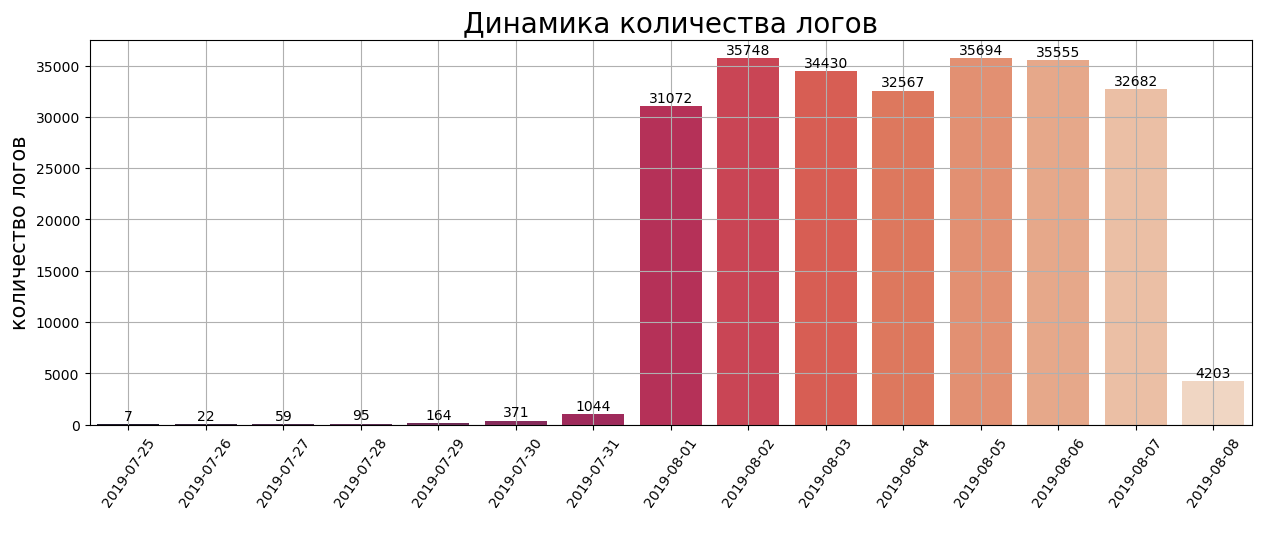

In [18]:
list_log = data.groupby('event_date')[['event_name']].count().reset_index()

plt.figure(figsize=(15, 5))
ax = sns.barplot(x='event_date', y='event_name', data=list_log, palette='rocket')

for x, y in list_log.iterrows():
    ax.text(x, y[1]+400, str(y[1]), ha='center')
        
plt.title('Динамика количества логов',fontsize = 20)
plt.xlabel(' ', fontsize = 15)
plt.xticks(rotation=55)
plt.ylabel('количество логов', fontsize = 15)
plt.grid(True)
plt.show()

Как видно на графике, у нас неполные данные:
- в период с 2019-07-25 по 2019-07-31 количество логов не превышает 2 тысяч;
- 2019-08-01 количество логов резко возрастает (в 18 раз) и остаётся примерно в этом же диапазоне до конца проведения A/A/B-эксперимента.

####  Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

Основываясь на предыдущих выводах, для дальнейшей работы возьмём данные за период с 2019-08-01 по 2019-08-07.

In [19]:
data_new = data.loc[data['event_datetime'] > '2019-07-31']

###  Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [20]:
print('Количество удалённых событий равно', data['event_name'].count() - data_new['event_name'].count(),\
     'или', '{0:.2%}'.format((data['event_name'].count() - data_new['event_name'].count())/data['event_name'].count()))
print('Количество удалённых пользователей равно', data['device_id_hash'].nunique() - data_new['device_id_hash'].nunique(),\
     'или', '{0:.2%}'.format((data['device_id_hash'].nunique() - data_new['device_id_hash'].nunique())/\
                             data['device_id_hash'].nunique()))

Количество удалённых событий равно 718 или 0.29%
Количество удалённых пользователей равно 8 или 0.11%


###  Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [21]:
data_groups = data_new.groupby('exp_id').agg({'device_id_hash': 'nunique'})
data_groups.columns = ['количество пользователей']
data_groups.index.names = ['группа эксперимента']
(data_groups
 .style
 .format('{0:,.0f}', subset='количество пользователей')
 .set_caption('Количество пользователей в разрезе экспериментальных групп')
 .set_table_styles([{'selector': 'caption', 
                    'props': [('color', 'black'), ('text-align','center'), ('font-size', '18px')]
                    }])
)

,количество пользователей
группа эксперимента,
A1,"2,486"
A2,"2,517"
B,"2,540"


Таким образом, пользователи есть во всех трёх экспериментальных группах и распределены практически одинаково (по 2,5 тысячи).

### Вывод по пункту 3
1. Всего в логе почти 244 тысячи событий.
2. Всего в логе 7,5 тысячи пользователей.
3. В среднем на пользователя приходится 32 события.
4. Максимальная дата равна 2019-08-07, минимальная дата равна 2019-07-25.
5. Так как у нас неполные данные в период с 2019-07-25 по 2019-07-31, для дальнейшей работы определены данные за период с 2019-08-01 по 2019-08-07.
6. Количество удалённых событий за период с 2019-07-25 по 2019-07-31 равно 796 или 0.33%, количество удалённых пользователей равно 9 или 0.12%.
7. Пользователи есть во всех трёх экспериментальных группах и распределены практически одинаково (по 2,5 тысячи).

## Изучите воронку событий.

### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [22]:
data_event = data_new.groupby('event_name').agg({'device_id_hash': 'count'})\
                     .sort_values(by='device_id_hash', ascending=False)

data_event['ratio'] = data_event['device_id_hash']/data_event['device_id_hash'].sum()

data_event.columns = ['количество событий', 'доля событий']
data_event.index.names = ['события']

(data_event
 .style
 .format('{0:,.0f}', subset='количество событий')
 .format('{0:,.2%}', subset='доля событий')
 .background_gradient(subset='доля событий', cmap='rocket')
 .set_caption('Количество событий в логах')
 .set_table_styles([{'selector': 'caption', 
                    'props': [('color', 'black'), ('text-align','center'), ('font-size', '22px')]
                    }])
)

,количество событий,доля событий
события,,
MainScreenAppear,"118,630",48.82%
OffersScreenAppear,"46,721",19.23%
CartScreenAppear,"42,567",17.52%
PaymentScreenSuccessful,"34,063",14.02%
Tutorial,"1,014",0.42%


Как видно из таблицы, чаще всего встречается событие MainScreenAppear, реже всего - Tutorial.

### Посчитайте, сколько пользователей совершали каждое из этих событий.
**Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.**

In [23]:
data_users = data_new.groupby('event_name').agg({'device_id_hash': 'nunique'})\
                     .sort_values(by='device_id_hash', ascending=False)

user_total = data_new['device_id_hash'].nunique()
data_users['ratio'] = data_users['device_id_hash']/user_total

data_users.columns = ['количество пользователей', 'доля пользователей']
data_users.index.names = ['события']

(data_users
 .style
 .format('{0:,.0f}', subset='количество пользователей')
 .format('{0:,.2%}', subset='доля пользователей')
 .background_gradient(subset='доля пользователей', cmap='rocket')
 .set_caption('Количество пользователей в разрезе событий')
 .set_table_styles([{'selector': 'caption', 
                    'props': [('color', 'black'), ('text-align','center'), ('font-size', '22px')]
                    }])
)

,количество пользователей,доля пользователей
события,,
MainScreenAppear,"7,430",98.50%
OffersScreenAppear,"4,608",61.09%
CartScreenAppear,"3,742",49.61%
PaymentScreenSuccessful,"3,542",46.96%
Tutorial,845,11.20%


Как видно, самая высокая конверсия у события MainScreenAppear, самая низкая - у Tutorial.

### Предположите, в каком порядке происходят события.
**Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.**

Как следует из полученных расчётов, у нас 5 (пять) событий:
1. MainScreenAppear - просмотр главной страницы.
2. OffersScreenAppear - просмотр страницы предложений.
3. CartScreenAppear - просмотр корзины.
4. PaymentScreenSuccessful - переход на страницу оплаты.
5. Tutorial - просмотр инструкции.

Таким образом, определим, что в воронку входят первые 4 (четыре) пункта, так как просмотр инструкции не явялется целевым действием.

In [24]:
print('Изначальное количество строк в датасете: ', '{0:,}'.format(count_rows_start).replace(',', ' '))
count_rows_before = data_new.shape[0]
data_result = data_new.query('event_name != "Tutorial"')
count_rows_after = data_result.shape[0]
print('-' * 80)
print('Количество удалённых строк всего: ', '{0:,}'.format(count_rows_start - count_rows_after).replace(',', ' '))
print('Доля удалённых строк: ', '{0:.2%}'.format((count_rows_start - count_rows_after)/count_rows_after))
print('Количество удалённых строк на текущем этапе: ',\
      '{0:,}'.format(count_rows_before - count_rows_after).replace(',', ' '))
print('-' * 80)
print('Количество строк после удаления: ', '{0:,}'.format(count_rows_after).replace(',', ' '))

Изначальное количество строк в датасете:  244 126
--------------------------------------------------------------------------------
Количество удалённых строк всего:  2 145
Доля удалённых строк:  0.89%
Количество удалённых строк на текущем этапе:  1 014
--------------------------------------------------------------------------------
Количество строк после удаления:  241 981


In [25]:
print('Количество удалённых событий равно', \
      '{0:,}'.format(data_new['event_name'].count() - data_result['event_name'].count()).replace(',', ' '),\
     'или', '{0:.2%}'.format((data_new['event_name'].count() - data_result['event_name'].count())/\
                             data_new['event_name'].count()))
print('Количество удалённых пользователей равно',\
      data_new['device_id_hash'].nunique() - data_result['device_id_hash'].nunique(),\
     'или', '{0:.2%}'.format((data_new['device_id_hash'].nunique() - data_result['device_id_hash'].nunique())/\
                             data_new['device_id_hash'].nunique()))

Количество удалённых событий равно 1 014 или 0.42%
Количество удалённых пользователей равно 4 или 0.05%


Теперь построим таблицу с конверсией на каждом этапе по очищенным данным.

In [26]:
data_users = data_result.groupby('event_name').agg({'device_id_hash': 'nunique'})\
                     .sort_values(by='device_id_hash', ascending=False)

user_total = data_result['device_id_hash'].nunique()
data_users['ratio'] = data_users['device_id_hash']/user_total

data_users.columns = ['количество пользователей', 'доля пользователей']
data_users.index.names = ['события']

(data_users
 .style
 .format('{0:,.0f}', subset='количество пользователей')
 .format('{0:,.2%}', subset='доля пользователей')
 .background_gradient(subset='доля пользователей', cmap='rocket')
 .set_caption('Количество пользователей в разрезе событий по очищенным данным')
 .set_table_styles([{'selector': 'caption', 
                    'props': [('color', 'black'), ('text-align','center'), ('font-size', '22px')]
                    }])
)

,количество пользователей,доля пользователей
события,,
MainScreenAppear,"7,430",98.55%
OffersScreenAppear,"4,608",61.12%
CartScreenAppear,"3,742",49.64%
PaymentScreenSuccessful,"3,542",46.98%


### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).
**То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.**

In [27]:
data_conv = data_users.drop('доля пользователей', axis=1)
data_conv['конверсия'] = data_conv['количество пользователей']/data_conv['количество пользователей'].shift(1)

(data_conv
 .style
 .format('{0:,.0f}', subset='количество пользователей')
 .format('{0:,.2%}', subset='конверсия')
 .background_gradient(subset='конверсия', cmap='rocket')
 .set_caption('Конверсия по очищенным данным')
 .set_table_styles([{'selector': 'caption', 
                    'props': [('color', 'black'), ('text-align','center'), ('font-size', '22px')]
                    }])
)

,количество пользователей,конверсия
события,,
MainScreenAppear,"7,430",nan%
OffersScreenAppear,"4,608",62.02%
CartScreenAppear,"3,742",81.21%
PaymentScreenSuccessful,"3,542",94.66%


Теперь визуализируем воронку продаж.

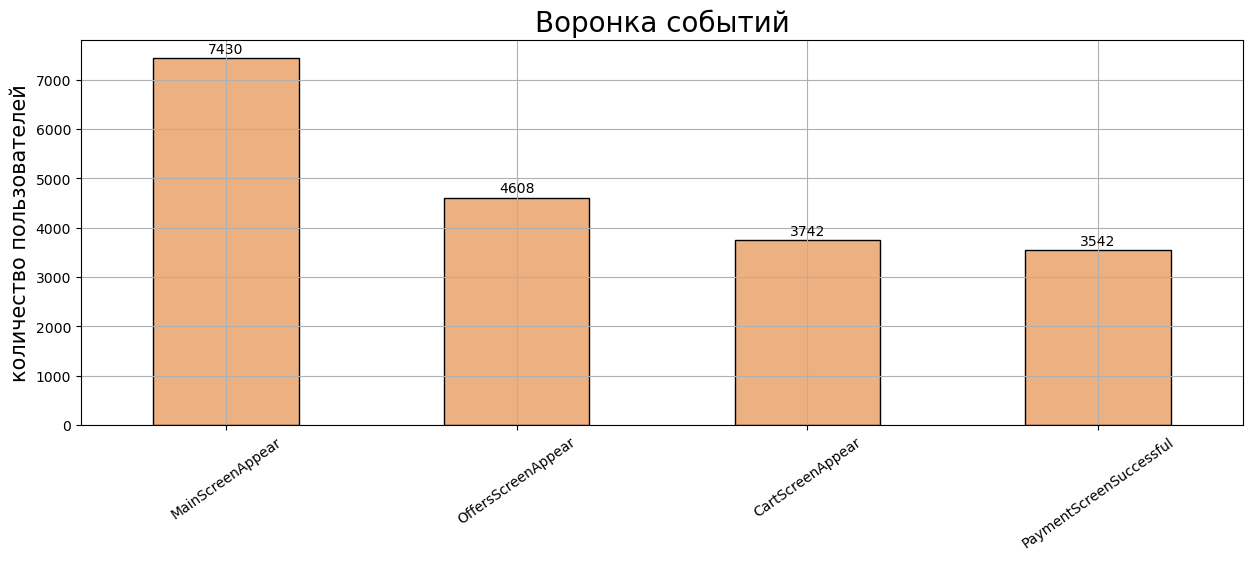

In [28]:
data_funnel = data_conv.drop('конверсия', axis=1)
data_funnel_list = data_funnel['количество пользователей'].tolist()
ax = data_funnel.plot(kind='bar', cmap='flare',grid=True, edgecolor='k', legend=None, figsize=(15, 5))

data_funnel = data_funnel.reset_index().sort_values(by='количество пользователей', ascending=True)
   
for x, y in data_funnel[::-1].iterrows():
    ax.text(x, y[1]+100, str(y[1]), ha='center')
    
plt.title('Воронка событий',fontsize = 20)
plt.xlabel(' ')
plt.ylabel('количество пользователей', fontsize = 15)
plt.xticks(rotation=35)
plt.show()

На графике видно, что самая высокая конверсия из шага 3 (CartScreenAppear - просмотр корзины) в шаг 4 (aymentScreenSuccessful - переход на страницу оплаты), самая низкая из шага 1 (MainScreenAppear - просмотр главной страницы) в шаг 2 (OffersScreenAppear - просмотр страницы предложений).

### На каком шаге теряете больше всего пользователей?

Как видно из таблицы, самая низкая конверсия из первого шага воронки (MainScreenAppear - просмотр главной страницы) во второй (OffersScreenAppear - просмотр страницы предложений).

Вероятно, пользователей, не перешедших на страницу товаров, не заинтересовывает главная страница мобильного приложения:
   - такие пользователи, возможно, не относятся к нашей целевой аудитории (если переходы по рекламным каналам, необходимо проводить анализ, чтобы не терять деньги);
   - или проблемы с главной страницей приложения (неудобный поиск по товарам, страница не побуждает совершить покупку или, хотя бы, посмотреть ассортимент товаров).

### Какая доля пользователей доходит от первого события до оплаты?

In [30]:
ratio = data_conv.iloc[3,0]/data_conv.iloc[0,0]
print('От первого события до оплаты доходят', '{0:,.2%}'.format(ratio), 'пользователей')

От первого события до оплаты доходят 47.67% пользователей


### Вывод по пункту 4
1. Чаще всего встречается событие MainScreenAppear, реже всего - Tutorial.

2. Самая высокая конверсия у события MainScreenAppear, самая низкая - у Tutorial.

3. В воронку входят первые 4 (четыре) пункта, так как просмотр инструкции не явялется целевым действием.

4. Самая высокая конверсия из шага 3 (CartScreenAppear - просмотр корзины) в шаг 4 (aymentScreenSuccessful - переход на страницу оплаты), самая низкая из шага 1 (MainScreenAppear - просмотр главной страницы) в шаг 2 (OffersScreenAppear - просмотр страницы предложений).

5. Самая низкая конверсия из первого шага воронки (MainScreenAppear - просмотр главной страницы) во второй (OffersScreenAppear - просмотр страницы предложений).
Вероятно, пользователей, не перешедших на страницу товаров, не заинтересовывает главная страница мобильного приложения:
- такие пользователи, возможно, не относятся к нашей целевой аудитории (если переходы по рекламным каналам, необходимо проводить анализ, чтобы не терять деньги);
- или проблемы с главной страницей приложения (неудобный поиск по товарам, страница не побуждает совершить покупку или, хотя бы, посмотреть ассортимент товаров).

6. От первого события до оплаты доходят 47.68% пользователей.

## Изучите результаты эксперимента.

### Сколько пользователей в каждой экспериментальной группе?

In [31]:
data_result_general = data_result.groupby('exp_id').agg({'device_id_hash': 'nunique'})
user_total = data_result_general['device_id_hash'].sum()
data_result_general['ratio'] = data_result_general['device_id_hash']/user_total

data_result_general.columns = ['количество пользователей', 'доля группы']
data_result_general.index.names = ['группа эксперимента']
(data_result_general
 .style
 .format('{0:,.0f}', subset='количество пользователей')
 .format('{0:,.2%}', subset='доля группы')
 .background_gradient(subset='доля группы', cmap='rocket')
 .set_caption('Количество пользователей в разрезе экспериментальных групп')
 .set_table_styles([{'selector': 'caption', 
                    'props': [('color', 'black'), ('text-align','center'), ('font-size', '18px')]
                    }])
)

,количество пользователей,доля группы
группа эксперимента,,
A1,"2,485",32.96%
A2,"2,516",33.37%
B,"2,538",33.66%


Таким образом, количество пользователей во всех трёх группах примерно одинаковое: около 33%. Также проверим есть ли пользователи, которые состоят более чем в одной группе.

In [30]:
count_clients = data_result.groupby('device_id_hash').agg({'exp_id': 'nunique'}).query('exp_id > 1').reset_index()
print('Количество пользователей, состоящих более чем в одной группе равно',\
     count_clients['device_id_hash'].count())

Количество пользователей, состоящих более чем в одной группе равно 0


### Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
**Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов.**

Необходимо проверить соблюдение критериев успешного A/A-теста: 
1. Количество пользователей в различных группах различается не более, чем на 1%.
2. Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же.
3. Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости.
4. Попавший в одну из групп посетитель остаётся в этой группе до конца теста.

В предыдущем пункте 5.1 уже проверили количество пользователей в экспериментальных группах:
- количество пользователей в контрольных группах (A1 и A2) различаются на 1,3% (относительная разница) и на 0,43 процентных пункта (абсолютная разница).

Также определили, что отсутствуют пользователи, состоящие более чем в одной группе.

Теперь необходимо проверить третий критерий успешного A/A-теста:
- различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости.

Для этого будем проводить проверку гипотезы о равенстве долей по каждому из 4 (четырёх) событий. Для этого сначала сформируем:
- таблицу с данными по всем экспериментальным группам в разрезе событий;
- таблицу с данными об общем количестве уникальных пользователей в разрезе групп (будем обращаться к ним и в дельнейшем)

и напишем общую функцию для расчёта p_value.

In [32]:
# подготовим данные по всем трём экспериментальным группам
data_A1 = data_result.loc[data_result['exp_id'] == 'A1']
data_A2 = data_result.loc[data_result['exp_id'] == 'A2']
data_B = data_result.loc[data_result['exp_id'] == 'B']

result_first_step_A1 = data_A1.groupby('event_name').agg({'device_id_hash': 'nunique'})\
.sort_values(by='device_id_hash', ascending=False)
result_first_step_A2 = data_A2.groupby('event_name').agg({'device_id_hash': 'nunique'})\
.sort_values(by='device_id_hash', ascending=False)
result_first_step_B = data_B.groupby('event_name').agg({'device_id_hash': 'nunique'})\
.sort_values(by='device_id_hash', ascending=False)

result_first_step_A = result_first_step_A1\
.merge(result_first_step_A2, left_on='event_name', right_on='event_name', how='inner')
result_steps = result_first_step_A\
.merge(result_first_step_B, left_on='event_name', right_on='event_name', how='inner')

result_steps.index.names = ['событие']
result_steps.columns = ['A1', 'A2', 'B']
result_steps['A1 + A2'] = result_steps['A1']+result_steps['A2']
result_steps['всего клиентов'] = result_steps['A1']+result_steps['A2']+result_steps['B']
result_steps['доля A1'] = result_steps['A1'] / result_steps['всего клиентов']
result_steps['доля A2'] = result_steps['A2'] / result_steps['всего клиентов']
result_steps['доля B'] = result_steps['B'] / result_steps['всего клиентов']
result_steps['доля A1 + A2'] = result_steps['A1 + A2'] / result_steps['всего клиентов']

In [33]:
result_steps_total = data_result.groupby('exp_id')['device_id_hash'].nunique().reset_index()
number = result_steps_total.loc[(result_steps_total['exp_id'] == 'A1')|(result_steps_total['exp_id'] == 'A2')]\
['device_id_hash'].sum()
result_steps_total.loc[3] = ['A1 + A2', number]

Выведем данные только по группам в A/A-тесте.

In [34]:
result_steps_control = result_steps[['A1', 'A2', 'всего клиентов', 'доля A1', 'доля A2']]
(result_steps_control
 .style
 .format('{0:,.0f}', subset=['A1', 'A2', 'всего клиентов'])
 .format('{0:,.2%}', subset=['доля A1', 'доля A2'])
 .set_caption('Количество пользователей A/A-теста')
 .set_table_styles([{'selector': 'caption', 
                    'props': [('color', 'black'), ('text-align','center'), ('font-size', '18px')]
                    }])
)

,A1,A2,всего клиентов,доля A1,доля A2
событие,,,,,
MainScreenAppear,"2,453","2,479","7,430",33.01%,33.36%
OffersScreenAppear,"1,545","1,527","4,608",33.53%,33.14%
CartScreenAppear,"1,267","1,239","3,742",33.86%,33.11%
PaymentScreenSuccessful,"1,200","1,159","3,542",33.88%,32.72%


Напишем функцию для проверки гипотезы о равенстве долей.

In [35]:
def hypo_result_function(number_alpha, successes_group1, successes_group2, number_total_1, number_total_2, name_of_event):
    """Функция для проверки гипотезы о равенстве долей."""
    alpha = number_alpha # критический уровень статистической значимости

    successes = np.array([result_steps.loc[name_of_event, successes_group1], \
                          result_steps.loc[name_of_event, successes_group2]])
    trials = np.array([number_total_1, number_total_2])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Событие (этап воронки продаж):', name_of_event)
    print('p_value равно ', float(p_value))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями групп', successes_group1,\
              'и', successes_group2, 'есть значимая разница.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп', successes_group1, 'и',\
              successes_group2, 'разными.')
    print('-'*80)

In [36]:
result_steps_total

,exp_id,device_id_hash
0,A1,2485
1,A2,2516
2,B,2538
3,A1 + A2,5001


In [37]:
result_steps_1 = result_steps[['A1', 'A2']]
number_total_1 = result_steps_total.iloc[0,1]
number_total_2 = result_steps_total.iloc[1,1]
for name_of_event in result_steps_1.index:
    alpha = 0.05
    hypo_result_function(alpha, 'A1', 'A2', number_total_1, number_total_2, name_of_event)
    print()

Событие (этап воронки продаж): MainScreenAppear
p_value равно  0.5793830190357201
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и A2 разными.
--------------------------------------------------------------------------------

Событие (этап воронки продаж): OffersScreenAppear
p_value равно  0.2818728044312424
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и A2 разными.
--------------------------------------------------------------------------------

Событие (этап воронки продаж): CartScreenAppear
p_value равно  0.21823550095390543
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и A2 разными.
--------------------------------------------------------------------------------

Событие (этап воронки продаж): PaymentScreenSuccessful
p_value равно  0.11510642249769809
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и A2 разными.
-------------------------------------------

Таким образом, статистически значимой разницы между группам A1 (246) и A2 (247) в разрезе событий нет.

Следовательно, можно сделать вывод об успешности A/A теста.

### Выберите самое популярное событие.
**1. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп.**

**2. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически 
достоверным.**

**3. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию).**

**4. Можно ли сказать, что разбиение на группы работает корректно?**

Исходя из ранее проведённого анализа, самое популярное событие - MainScreenAppear (просмотр главной страницы). Сформируем таблицу для контрольных групп (A1, A2).

In [38]:
result_steps_2 = result_steps.loc[result_steps.index == 'MainScreenAppear'][['A1', 'A2', 'доля A1', 'доля A2']]
(result_steps_2
 .style
 .format('{0:,.0f}', subset=['A1', 'A2'])
 .format('{0:,.2%}', subset=['доля A1', 'доля A2'])
 .set_caption('Количество пользователей A/A теста на самом популярном событии')
 .set_table_styles([{'selector': 'caption', 
                    'props': [('color', 'black'), ('text-align','center'), ('font-size', '18px')]
                    }])
)

,A1,A2,доля A1,доля A2
событие,,,,
MainScreenAppear,"2,453","2,479",33.01%,33.36%


В каждой группе самое популярное событие (MainScreenAppear (просмотр главной страницы)) совершили почти 2,5 тысячи человек. Как видно из таблицы, что пользователи практически одинаково распределены по группам (около 33-34%).

Ещё раз выведем результаты расчёта статистической значимости разности долей.

In [39]:
number_total_1 = result_steps_total.iloc[0,1]
number_total_2 = result_steps_total.iloc[1,1]

hypo_result_function(0.05, 'A1', 'A2', number_total_1, number_total_2, 'MainScreenAppear')

Событие (этап воронки продаж): MainScreenAppear
p_value равно  0.5793830190357201
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и A2 разными.
--------------------------------------------------------------------------------


Ещё раз выведем результаты расчёта статистической значимости разности долей между контрольными группами по другим событиям.

In [40]:
list_event = ['OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

number_total_1 = result_steps_total.iloc[0,1]
number_total_2 = result_steps_total.iloc[1,1]
for name_of_event in list_event:
    alpha = 0.05
    hypo_result_function(alpha, 'A1', 'A2', number_total_1, number_total_2, name_of_event)
    print()

Событие (этап воронки продаж): OffersScreenAppear
p_value равно  0.2818728044312424
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и A2 разными.
--------------------------------------------------------------------------------

Событие (этап воронки продаж): CartScreenAppear
p_value равно  0.21823550095390543
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и A2 разными.
--------------------------------------------------------------------------------

Событие (этап воронки продаж): PaymentScreenSuccessful
p_value равно  0.11510642249769809
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и A2 разными.
--------------------------------------------------------------------------------



Таким образом, делаем вывод, что разбиение на группы работает корректно.

### Аналогично поступите с группой с изменённым шрифтом.
**1. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию.**

**2. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?**

Рассчитаем статистическую значимость разности долей между контрольными и тестовой группами. Используем поправку Бонферрони для множественных сравнений (разделим уровень статистической значимости на 16 (столько всего у нас проверок результатов тестирования)).

In [41]:
result_steps_4 = result_steps[['A1', 'B']]

number_total_1 = result_steps_total.iloc[0,1]
number_total_2 = result_steps_total.iloc[2,1]
for name_of_event in result_steps_4.index:
    alpha = 0.05/16
    hypo_result_function(alpha, 'A1', 'B', number_total_1, number_total_2, name_of_event)
    print()

Событие (этап воронки продаж): MainScreenAppear
p_value равно  0.3900609939665136
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и B разными.
--------------------------------------------------------------------------------

Событие (этап воронки продаж): OffersScreenAppear
p_value равно  0.22907005590620733
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и B разными.
--------------------------------------------------------------------------------

Событие (этап воронки продаж): CartScreenAppear
p_value равно  0.10519224200668087
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и B разными.
--------------------------------------------------------------------------------

Событие (этап воронки продаж): PaymentScreenSuccessful
p_value равно  0.23368891375831957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и B разными.
----------------------------------------------

Различий между контрольной A1 и тестовой B группами не найдено. Стоит отметить, что даже без учёта поправки Бонферрони для множественных сравнений, уровень p_value значительно выше обычного уровня статистической значимости в 5%.

Теперь перейдём к сравнению A2 и B групп.

In [42]:
result_steps_5 = result_steps[['A2', 'B']]
number_total_1 = result_steps_total.iloc[1,1]
number_total_2 = result_steps_total.iloc[2,1]
for name_of_event in result_steps_4.index:
    alpha = 0.05/16
    hypo_result_function(alpha, 'A2', 'B', number_total_1, number_total_2, name_of_event)
    print()

Событие (этап воронки продаж): MainScreenAppear
p_value равно  0.7595837257920652
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A2 и B разными.
--------------------------------------------------------------------------------

Событие (этап воронки продаж): OffersScreenAppear
p_value равно  0.9007258094194959
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A2 и B разными.
--------------------------------------------------------------------------------

Событие (этап воронки продаж): CartScreenAppear
p_value равно  0.6983295296960459
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A2 и B разными.
--------------------------------------------------------------------------------

Событие (этап воронки продаж): PaymentScreenSuccessful
p_value равно  0.6969580996470051
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A2 и B разными.
-------------------------------------------------

Здесь такая же ситуация, как и при сравнении тестовой группы B с контрольной группой A1. Следовательно, введение новых шрифтов не привело к увеличению конверсии (росту продаж).

Теперь сравним результаты с объединённой контрольной группой.

In [43]:
result_steps_6 = result_steps[['A1 + A2', 'B']]
number_total_1 = result_steps_total.iloc[3,1]
number_total_2 = result_steps_total.iloc[2,1]
for name_of_event in result_steps_4.index:
    alpha = 0.05/16
    hypo_result_function(alpha, 'A1 + A2', 'B', number_total_1, number_total_2, name_of_event)
    print()

Событие (этап воронки продаж): MainScreenAppear
p_value равно  0.4997899191897228
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 + A2 и B разными.
--------------------------------------------------------------------------------

Событие (этап воронки продаж): OffersScreenAppear
p_value равно  0.4448907129599069
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 + A2 и B разными.
--------------------------------------------------------------------------------

Событие (этап воронки продаж): CartScreenAppear
p_value равно  0.24715186728909577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 + A2 и B разными.
--------------------------------------------------------------------------------

Событие (этап воронки продаж): PaymentScreenSuccessful
p_value равно  0.6457891141255783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 + A2 и B разными.
----------------------------

Значимой разницы нет, так как разницы в долях между трёмя группами (контрольными A1 и A2 и тестовой B) нет, следовательно, и у объединённой контрольной группы разницы в долях с тестовой группой B также нет.

### Какой уровень значимости вы выбрали при проверке статистических гипотез выше?
**1. Посчитайте, сколько проверок статистических гипотез вы сделали.**

**2. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить?**

**3. Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.**

Всего проведено 16 проверок статических гипотез. Следовательно, учитывая поправку Бонферрони для множественных сравнений, необходимо разделить уровень статической значимости на 16. То есть, 0.1 поделить на 16 (получаем 0.00625).

Так как только проверки статических гипотез по объединённой контрольной и тестовой группам определили наличие значимой разницы, а в других p_value значительно выше уровня статической значимости в 10%, то перепроверим только те проверки, где определено наличие значимой разницы.

In [44]:
result_steps_6 = result_steps[['A1 + A2', 'B']]
number_total_1 = result_steps_total.iloc[3,1]
number_total_2 = result_steps_total.iloc[2,1]
for name_of_event in result_steps_4.index:
    alpha = 0.01/16
    hypo_result_function(alpha, 'A1 + A2', 'B', number_total_1, number_total_2, name_of_event)
    print()

Событие (этап воронки продаж): MainScreenAppear
p_value равно  0.4997899191897228
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 + A2 и B разными.
--------------------------------------------------------------------------------

Событие (этап воронки продаж): OffersScreenAppear
p_value равно  0.4448907129599069
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 + A2 и B разными.
--------------------------------------------------------------------------------

Событие (этап воронки продаж): CartScreenAppear
p_value равно  0.24715186728909577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 + A2 и B разными.
--------------------------------------------------------------------------------

Событие (этап воронки продаж): PaymentScreenSuccessful
p_value равно  0.6457891141255783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 + A2 и B разными.
----------------------------

Всё равно, несмотря на применение множественной поправки Бонферрони, разницы в долях нет.

### Вывод по пункту 5
1. Количество пользователей во всех трёх группах примерно одинаковое: около 2,5 тысяч или 33% от общего количества клиентов.

2. A/A тест является успешным. *(количество пользователей в контрольных группах примерно равно и различается на 1,3% (относительная разница) и на 0,43 процентных пункта (абсолютная разница), пользователи, состоящие более чем в одной группе, отсутствуют, различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости)*

3. Разбиение на группы контрольные группы работает корректно.

4. Различий между контрольными A1 и A2 и тестовой B группами не найдено. Стоит отметить, что даже без учёта поправки Бонферрони для множественных сравнений, уровень p_value значительно выше обычного уровня статистической значимости в 5%. Следовательно, введение новых шрифтов не привело к увеличению конверсии (росту продаж).

5. При сравнении объединённой контрольной и B групп значимой разницы не установлено, так как разницы в долях между трёмя группами (контрольными A1 и A2 и тестовой B) нет, следовательно, и у объединённой контрольной группы разницы в долях с тестовой группой B также нет.

6. Применение множественной поправки Бонферрони не повлияло на предыдущие выводы исследования.

## Общий вывод.

1. Перед проведением исследования удалены 0.92% или 2,2 тысячи строк (2 223 строки, из которых: 413 строк - дубликаты, 796 строк - вне выбранного для анализа периода времени, 1 014 строк - не относятся к воронке событий (этап Tutorial - просмотр инструкции). 

2. Для целей настоящего исследования взят период с 2019-08-01 по 2019-08-07 (до 2019-08-01 у нас неполные данные, которые исказили бы дальнейшие выводы).

3. Воронка событий:
- в неё входят 4 (четыре) пункта (просмотр инструкции, Tutorial, не является целевым действием);
- самая низкая конверсия из первого шага воронки (MainScreenAppear - просмотр главной страницы) во второй (OffersScreenAppear - просмотр страницы предложений). Вероятно, пользователей, не перешедших на страницу товаров, не заинтересовывает главная страница мобильного приложения:
    - такие пользователи, возможно, не относятся к нашей целевой аудитории (если переходы по рекламным каналам, необходимо проводить анализ, чтобы не терять деньги);
    - или проблемы с главной страницей приложения (неудобный поиск по товарам, страница не побуждает совершить покупку или, хотя бы, посмотреть ассортимент товаров);
- от первого события до оплаты доходят 47.68% пользователей.

4. Результаты эксперимента A/A/B тестирование:
- A/A тест является успешным. *(количество пользователей в контрольных группах примерно равно и различается на 1,3% (относительная разница) и на 0,43 процентных пункта (абсолютная разница), пользователи, состоящие более чем в одной группе, отсутствуют, различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости)*;
- различий между контрольными A1 и A2 и тестовой B группами не найдено. Следовательно, введение новых шрифтов не привело к увеличению конверсии (росту продаж);
- при сравнении объединённой контрольной и B групп значимой разницы не установлено, так как разницы в долях между трёмя группами (контрольными A1 и A2 и тестовой B) нет, следовательно, и у объединённой контрольной группы разницы в долях с тестовой группой B также нет;
- применение множественной поправки Бонферрони не повлияло на предыдущие выводы исследования.